<a href="https://colab.research.google.com/github/lanyu0322/phd_semester1/blob/master/NYC_jobs%EF%BC%88final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 #LEHD data for NYC.  And make a choropleth of the number of workers to residents.
  

In [0]:
from google.colab import drive
drive.mount("/content/drive")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install geopandas

In [0]:
import time
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import pyproj as proj
import pandas as pd

In [0]:
wname = "drive/My Drive/lwir/data/nyc_ratio/ny_wac_S000_JT00_2017.csv"
rname = "drive/My Drive/lwir/data/nyc_ratio/ny_rac_S000_JT00_2017.csv"
tname = "drive/My Drive/lwir/data/nyc_ratio/ny_od_main_JT00_2017.csv"



In [0]:
wdata = pd.read_csv(wname)
wdata.head()



,w_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,CFA01,CFA02,CFA03,CFA04,CFA05,CFS01,CFS02,CFS03,CFS04,CFS05,createdate
0,360010001001004,5,1,3,1,2,2,1,0,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,0,0,0,4,1,0,0,0,0,4,1,2,1,0,1,2,3,0,0,0,0,0,0,0,0,0,0,20190825
1,360010001001005,57,11,39,7,3,8,46,0,0,0,44,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,1,0,0,0,0,54,3,7,15,17,7,50,7,0,0,0,0,0,0,0,0,0,0,20190825
2,360010001001006,43,5,27,11,1,5,37,0,0,0,0,0,0,0,0,0,0,38,5,0,0,0,0,0,0,0,0,39,3,0,0,0,1,42,1,7,11,8,12,41,2,0,0,0,0,0,0,0,0,0,0,20190825
3,360010001001008,104,28,53,23,17,30,57,0,0,0,20,0,82,0,0,0,0,0,0,0,0,2,0,0,0,0,0,79,13,0,10,0,2,100,4,12,26,21,17,79,25,0,0,0,0,0,0,0,0,0,0,20190825
4,360010001001010,3,1,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,3,0,0,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,20190825


In [0]:
print(len(wdata))

tdata = pd.read_csv(tname)


107774


In [0]:
wtotal = wdata['C000'].sum()



In [0]:
rdata = pd.read_csv(rname)


In [0]:
len(rdata)

231315

In [0]:
# Creating the map:
# # 1. merge wdata and rdata on the "geocode" columns (with suffixes "_w" and "_h") and fill NaNs with zeros (fillna is the method)
wdata = pd.read_csv(wname)
rdata = pd.read_csv(rname)
# display(wdata.head(), rdata.head())


# ===== wrong one
# merged = pd.merge(wdata[["w_geocode", 'C000']], rdata[["h_geocode",'C000']], left_on="w_geocode", right_on="h_geocode", suffixes=["_w", "_h"], how='outer', left_index=True)
# print(merged)
# merged[['C000_w', 'C000_h']] = merged[['C000_w','C000_h']].fillna(value=0) 
# print(merged)

wdata.rename(columns = {'w_geocode': 'GEOID10'}, inplace=True)
rdata.rename(columns = {'h_geocode': 'GEOID10'}, inplace=True)

merged = pd.merge(wdata[["GEOID10", 'C000']], rdata[["GEOID10",'C000']], on="GEOID10", suffixes=["_w", "_h"], how='outer')
#print(merged)


In [0]:
# # 2. sum the C000_w and C000_h columns and add the result to the output of 1.
merged[['C000_w', 'C000_h']] = merged[['C000_w','C000_h']].fillna(value=0) 
merged['total'] = merged['C000_w'] + merged['C000_h']
#print(merged)

In [143]:
#3. get the census blocks shapefile for NY state (either census data website or bytes of the big apple website)
# 4. sub-sample to only Manhattan
fname = "drive/My Drive/lwir/data/nyc_ratio/tl_2019_36_tabblock10/tl_2019_36_tabblock10.shp"
#data source:https://www2.census.gov/geo/tiger/TIGER2019/TABBLOCK/
#data agenda:https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf

t0 = time.time()
print("reading census tract shapes for NY state")
data = gp.read_file(fname)
print("  read in {0}s".format(time.time() - t0))
data.head()

# 005 # Bronx County
# 047 # Kings County (Brooklyn)
# 081 # Queens County
# 085 # Richmond County (Staten Island)

# manhattan = data["COUNTRYPF10"] == "061"  wrong one, because the output is true/false
# ind = (data.COUNTYFP10 == "005") | (data.COUNTYFP10 == "047") | \
#   (data.COUNTYFP10 == "061") | (data.COUNTYFP10 == "081") | \
#   (data.COUNTYFP10 == "085") manhattan = data[data.COUNTYFP10 == "061"]
manhattan = data[data.COUNTYFP10 == "061"]
#manhattan = data[ind] # all NYC counties
#061 - New York (Manhattan) source: https://test.library.columbia.edu/services/research-data-services/guides/population/nycounty_fips.html
#manhattan.head()
#print(manhattan)


reading census tract shapes for NY state
  read in 34.380091428756714s


In [0]:
# 5. merge the output of 2. into the geodataframe of 4.
manhattan['GEOID10'] = manhattan['GEOID10'].astype(int) #the orginal type is object, we use this sentence to transfer interge 就是他本来的type是object，然后通过这句话把它转成int, 数据类型一致了下面才能merge
# “You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat”，意思就是一个数据类型是int，一个是object

sub = manhattan.merge(merged, on='GEOID10', how='left')
sub[['C000_w', 'C000_h']] = sub[['C000_w','C000_h']].fillna(value=0) 
sub['total'] = sub['C000_w'] + sub['C000_h']
print(sub)


In [0]:
# -- remove census tracts with 0 residents or workers
#sub_nz = sub[sub.total != 0]

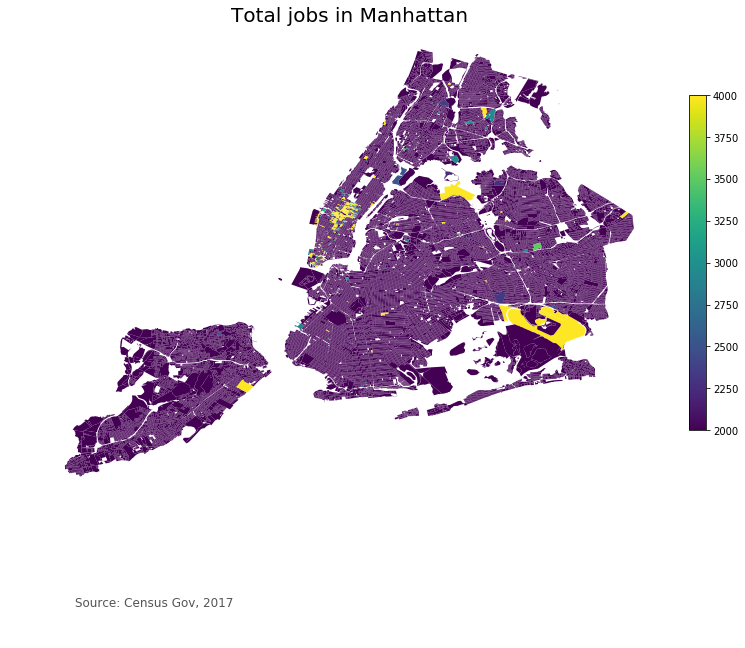

In [0]:
#6. plot the map of 2

# set the filepath and load in a shapefile
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
nyc_jobs = "total"
# vmin, vmax = 0, 28323 #better way: sub['total'].min()/max
vmin, vmax = 2000, 4000 #better way: sub['total'].min()/max
fig, ax = plt.subplots(1, figsize=(12, 12))
sub_nz.plot(column=nyc_jobs, cmap='viridis', linewidth=0.0, ax=ax, edgecolor='0.3', vmin=vmin, vmax=vmax)
ax.axis("off")
ax.set_title("Total jobs in Manhattan", fontdict={"fontsize": "20", "fontweight": "7"})
ax.annotate("Source: Census Gov, 2017",xy=(0.1, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))                # normalize意思就是把所有的数据都归一化，意思就是把所有数据按比例整理一下，这里的比例就是括号里的最大最小值，比如有5个数[1.34, 3.34, 4.32, 3, 5.43], 按[0,1]归一化以后就是 [0.134, 0.334, 0.432, 0.3, 0.543]
sm._A = [] # empty array for the data range                                                   # 我查了一下源码，_A应该是这个cm （color map）的一个变量，是一个数组，意思就是标识数据范围的一个array，应该不用管，传个空的就是了
cbar = fig.colorbar(sm,fraction=0.025, pad=0.04) # add the colorbar to the figure


plotting workers...
plotting residents...
plotting total...


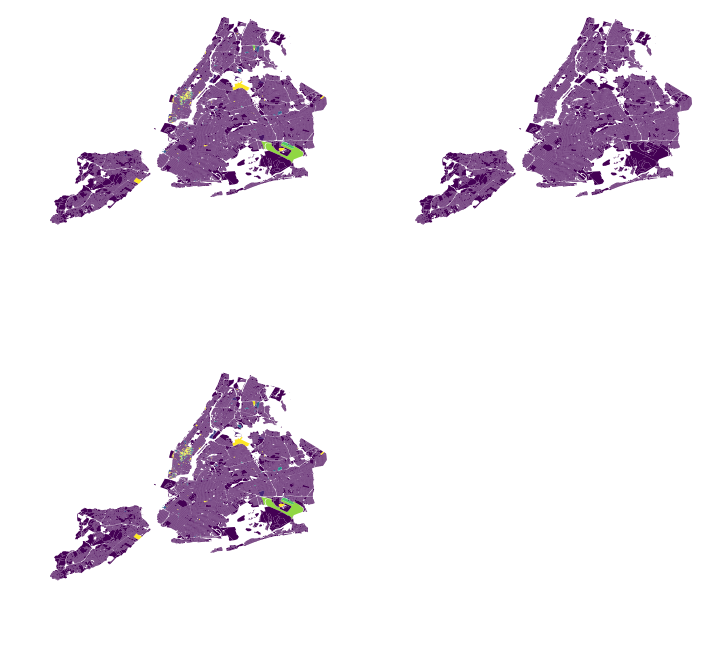

In [0]:
# -- plot workers, residents, and total side by side
clim    = (2000, 5000)
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
[i.axis("off") for j in ax for i in j]

print("plotting workers...")
sub_nz.plot(column="C000_w", lw=0.0, ax=ax[0][0], vmin=clim[0], vmax=clim[1])
print("plotting residents...")
sub_nz.plot(column="C000_h", lw=0.0, ax=ax[0][1], vmin=clim[0], vmax=clim[1])
print("plotting total...")
sub_nz.plot(column="total", lw=0.0, ax=ax[1][0], vmin=clim[0], vmax=clim[1])



# nyc_jobs = "total"
# # vmin, vmax = 0, 28323 #better way: sub['total'].min()/max
# vmin, vmax = 2000, 4000 #better way: sub['total'].min()/max
# fig, ax = plt.subplots(1, figsize=(12, 12))
# sub_nz.plot(column=nyc_jobs, cmap='viridis', linewidth=0.0, ax=ax, edgecolor='0.3', vmin=vmin, vmax=vmax)
# ax.axis("off")
# ax.set_title("Total jobs in Manhattan", fontdict={"fontsize": "20", "fontweight": "7"})
# ax.annotate("Source: Census Gov, 2017",xy=(0.1, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")
# # Create colorbar as a legend
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))                # normalize意思就是把所有的数据都归一化，意思就是把所有数据按比例整理一下，这里的比例就是括号里的最大最小值，比如有5个数[1.34, 3.34, 4.32, 3, 5.43], 按[0,1]归一化以后就是 [0.134, 0.334, 0.432, 0.3, 0.543]
# sm._A = [] # empty array for the data range                                                   # 我查了一下源码，_A应该是这个cm （color map）的一个变量，是一个数组，意思就是标识数据范围的一个array，应该不用管，传个空的就是了
# cbar = fig.colorbar(sm,fraction=0.025, pad=0.04) # add the colorbar to the figure


In [0]:
# -- how many have 0 workers plus residents?
print((sub.total == 0).sum())
print(len(sub))

5930
39148


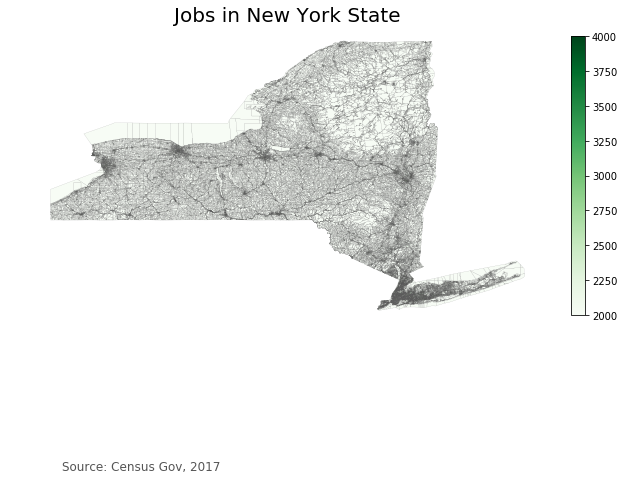

In [0]:
wdata.rename(columns = {'w_geocode': 'GEOID10'}, inplace=True)
rdata.rename(columns = {'h_geocode': 'GEOID10'}, inplace=True)

merged = pd.merge(wdata[["GEOID10", 'C000']], rdata[["GEOID10",'C000']], on="GEOID10", suffixes=["_w", "_h"], how='outer')

fname = "drive/My Drive/lwir/data/nyc_ratio/tl_2019_36_tabblock10/tl_2019_36_tabblock10.shp"
#data source:https://www2.census.gov/geo/tiger/TIGER2019/TABBLOCK/
#data agenda:https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf
data = gp.read_file(fname)
data.head()
data['GEOID10'] = data['GEOID10'].astype(int) 
ny_state = data.merge(merged, on='GEOID10', how='left')
ny_state[['C000_w', 'C000_h']] = ny_state[['C000_w','C000_h']].fillna(value=0) 
ny_state['total'] = ny_state['C000_w'] + ny_state['C000_h']
#print(ny_state)
jobs = "total"
tmin, tmax = 1, 11814
fig, ax = plt.subplots(1, figsize=(10,10))
ny_state.plot(column=jobs, cmap='Greens', linewidth=0.08, ax=ax, edgecolor='0.3')
ax.axis("off")
ax.set_title("Jobs in New York State", fontdict={"fontsize": "20", "fontweight": "7"})
ax.annotate("Source: Census Gov, 2017",xy=(0.1, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax)) # Create colorbar as a legend
sm._A = [] # empty array for the data range
cbar = fig.colorbar(sm,fraction=0.025, pad=0.04) # add the colorbar to the figure


In [0]:

#Let's put together the parks and LEHD notebooks so that we can have integrated square 
# footage and W+R within some "aperture" (aka radius) around each camera lat/lon.  
# Once we have that, 
# let's also look at a scatter plot of those two quantities.  Once we have those two, I'll give you the foot traffic data.


# Bear in mind that when integrating the parks data,
# it's easy: inside park is 1 outside park is 0. 
# For W+R it's a bit more complicated.  
# Once the intersection is done,
# you have a geodataframe with a series of gemoetries, many of which are empty.  
# For each of those geometries, you can calculate the area and what you want for that geometry is the fraction of W+R that that area represents.


In [0]:
GEOID10=sub['GEOID10']
import pyproj
from shapely.geometry import Point  

def area_fraction(geometry, lat, lon, rad):
  circle = Point(lat,lon).buffer(rad)
  inter = geometry.intersection(circle)  
  result = inter.area/geometry.area
  return result


sub = sub.to_crs(epsg=2263)  
gemo = sub['geometry']
lname = "drive/My Drive/lwir/data/nycdot/cams_latlon.npy"
latlon = np.load(lname)

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result


ny_lat, ny_lon = latlon_to_ny(latlon[:, 0], latlon[:, 1])
ny_latlon = np.vstack((ny_lat, ny_lon)).T


rad = 500.
total_people = []
for i in range(ny_latlon.shape[0]):
  jarea = area_fraction(gemo, ny_latlon[i][0], ny_latlon[i][1], rad)
  totaljobs = jarea * sub["total"]
  jobstotal = totaljobs.sum()
  total_people.append(jobstotal)
  
#total_people = np.array(total_people)
print(total_people)


In [0]:
# print(jarea)
# print(totaljobs)
print(total_people)



[346.77553587831216, 2380.836833051221, 310.13647060204755, 5239.605355543635, 507.07407667396797, 377.13865886793644, 20547.880379791866, 3688.7741566760633, 5583.415766656208, 1806.1734822913877, 215.0783625603937, 4139.695009976893, 312.44004850947226, 2748.493759238196, 5910.363278840351, 768.29314651137, 714.5044595923903, 759.202983547404, 12288.998572349163, 2126.544345732951, 12189.36760977959, 19951.033172130898, 23219.880756315695, 26518.277277813715, 13969.084751438588, 16691.111644663233, 2448.8261558933755, 977.4507290286982, 1171.3209550231027, 356.85377446773225, 850.7692628933218, 1852.3422146771563, 1996.4073310987544, 3650.871060954546, 25021.77620021097, 8940.992289753056, 9857.639961005862, 0.0, 15883.108536767071, 12389.012553075694, 29452.28998336856, 14458.029559049997, 17123.910406827737, 26385.146858403103, 1157.526013691353, 4963.416041005082, 45986.7681768972, 4919.029070182389, 23914.558363283446, 4180.003408843564, 17730.898875800824, 4596.37509964092, 4251

In [0]:
def available_greenspace(geometry, lat, lon, rad):
  circle = Point(lat,lon).buffer(rad)
  parea = geometry.intersection(circle)   
  result = parea.area.sum()
  return result

#intersection_parks = park.geometry.intersection(circle)     
# -- Read parks properties
#props = READ IN THE PROPOERTIES FILE
fname = "drive/My Drive/lwir/data/parks/properties/geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"

#read the godataframe and # -- Convert to NYSP coords

park = gp.GeoDataFrame.from_file(fname)
park = park.to_crs(epsg=2263) 
gemo = park['geometry']




lname = "drive/My Drive/lwir/data/nycdot/cams_latlon.npy"
latlon = np.load(lname)
# len(latlon) #281

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result



ny_lat, ny_lon = latlon_to_ny(latlon[:, 0], latlon[:, 1])
ny_latlon = np.vstack((ny_lat, ny_lon)).T




rad = 500.


greenarea_size = []

for i in range(ny_latlon.shape[0]): #for in in range(len(latton))

  tarea = available_greenspace(gemo, ny_latlon[i][0], ny_latlon[i][1], rad)
  greenarea_size.append(tarea)

#greenareaa_size = np.array(greenarea_size)
print(greenarea_size)
 


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#  fname = []
#  for i in range(ny_latlon.shape[0]):
#   file_name = (latlon[i][0], latlon[i][1], greenarea_size[i], total_people[i])
#   fname.append(file_name)
#  print(fname)
  

[(40.738943, -73.81504699999999, 0.0, 346.77553587831216), (40.7335677903, -73.8693237305, 979.8064743176856, 2380.836833051221), (40.635735, -74.083777, 0.0, 310.13647060204755), (40.7166231327, -73.9991855621, 45023.62456460086, 5239.605355543635), (40.7536616175, -73.89859199520001, 0.0, 507.07407667396797), (40.570469, -74.109749, 0.0, 377.13865886793644), (40.761268375300006, -73.9835643768, 0.0, 20547.880379791866), (40.6832090347, -73.9769983292, 0.0, 3688.7741566760633), (40.7702068285, -73.9868688583, 0.0, 5583.415766656208), (40.680209000000005, -73.75335600000001, 0.0, 1806.1734822913877), (40.667436, -73.766763, 0.0, 215.0783625603937), (40.718427, -73.99483000000001, 58445.16428738835, 4139.695009976893), (40.669201, -73.99665, 0.0, 312.44004850947226), (40.786516, -73.95245600000001, 19998.479163659733, 2748.493759238196), (40.7584403234, -73.9649391174, 0.0, 5910.363278840351), (40.75391, -73.901201, 0.0, 768.29314651137), (40.752424, -74.000899, 27738.52437648816, 714.5

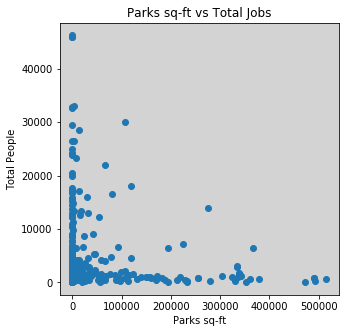

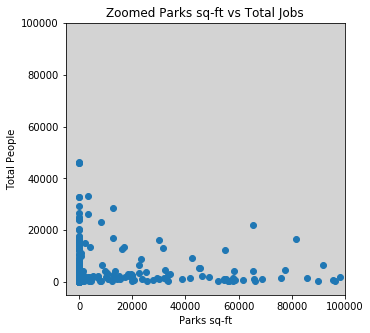

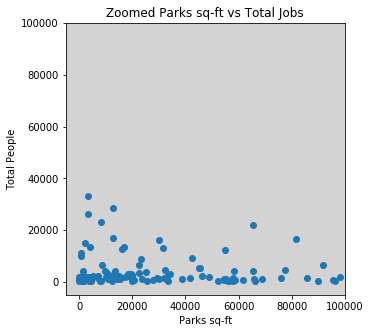

In [0]:
#a scatter plot of parks sq-ft and W+R where each point is a camera location
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title('Parks sq-ft vs Total Jobs')
ax.set_xlabel('Parks sq-ft')
ax.set_ylabel('Total People')
ax.set_facecolor("lightgray")
plt.scatter(greenarea_size, total_people)


# zoomed plot
fig1, ax1 = plt.subplots(figsize=(5, 5))

ax1.set_title('Zoomed Parks sq-ft vs Total Jobs')
ax1.set_xlabel('Parks sq-ft')
ax1.set_ylabel('Total People')
ax1.set_facecolor("lightgray")
plt.axis([-5000, 100000, -5000, 100000])
plt.scatter(greenarea_size, total_people)



# ====
greenarea_size_temp = []
total_people_temp = []

for i in range(len(greenarea_size)):
  if greenarea_size[i] != 0:
    greenarea_size_temp.append(greenarea_size[i])
    total_people_temp.append(total_people[i])
    

fig2, ax2 = plt.subplots(figsize=(5, 5))
# drop the variables when green_space=0
ax2.set_title('Zoomed Parks sq-ft vs Total Jobs')
ax2.set_xlabel('Parks sq-ft')
ax2.set_ylabel('Total People')
ax2.set_facecolor("lightgray")
plt.axis([-5000, 100000, -5000, 100000])
plt.scatter(greenarea_size_temp, total_people_temp)







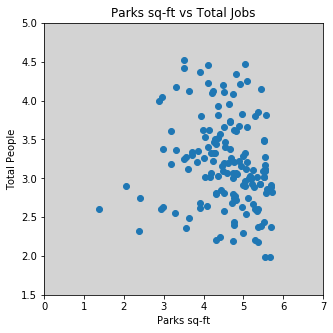

In [138]:
import math 
fname = []
log10_greenarea_size = []
log10_total_people = []
for i in range(len(greenarea_size_temp)):
  log10_greenarea_size.append(math.log10(greenarea_size_temp[i]))
  log10_total_people.append(math.log10(total_people_temp[i]))
                                  
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title('Parks sq-ft vs Total Jobs')
ax.set_xlabel('Parks sq-ft')
ax.set_ylabel('Total People')
ax.set_facecolor("lightgray")
plt.axis([0, 7, 1.5, 5])
plt.scatter(log10_greenarea_size, log10_total_people)

In [0]:
manhattan
manhattan = data[data.COUNTYFP10 == "061"]

In [150]:

import pyproj
from shapely.geometry import Point  

def area_fraction(geometry, lat, lon, rad):
  circle = Point(lat,lon).buffer(rad)
  inter = geometry.intersection(circle)  
  result = inter.area/geometry.area
  return result


manhattan = manhattan.to_crs(epsg=2263)  
gemo = manhattan['geometry']
lname = "drive/My Drive/lwir/data/nycdot/cams_latlon.npy"
latlon = np.load(lname)

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result


ny_lat, ny_lon = latlon_to_ny(latlon[:, 0], latlon[:, 1])
ny_latlon = np.vstack((ny_lat, ny_lon)).T



  
# #total_people = np.array(total_people)
# print(total_people)
rad = 500.
total_people_manhattan = []
for i in range(ny_latlon.shape[0]):
  jarea = area_fraction(gemo, ny_latlon[i][0], ny_latlon[i][1], rad)
  totaljobs = jarea * sub["total"]
  jobstotal = totaljobs.sum()
  total_people_manhattan.append(jobstotal)
  
#total_people = np.array(total_people)
print(total_people_manhattan)

[0.0, 0.0, 0.0, 116.91897902113713, 0.0, 0.0, 0.0, 0.0, 20.236536617050596, 0.0, 0.0, 0.0, 0.0, 38.527010694348725, 11.425468312896221, 0.0, 122.19785757096098, 0.0, 156.29709477133218, 188.36867460165323, 31.911424861035748, 487.1597784425775, 98.1156342671355, 0.0, 0.0, 34.12632219975487, 0.0, 0.0, 184.7735226861862, 1996.104180870791, 82.0, 0.0, 0.13955765811187473, 140.86407778785622, 54.32653329350819, 95.30664850327928, 129.0945630623752, 0.0, 0.0, 779.2227884563207, 73.85759360343076, 43.5824544436679, 5.432217626481556, 0.0, 250.2381302637541, 3.085628117092529, 0.0, 382.76873388265926, 251.1298948006424, 16.874103861736952, 171.3311990755504, 13.289193429761896, 137.7682098271718, 124.35017026121396, 367.0, 4.658480062722367, 21.26621130700109, 40.49752881884607, 94.27710054618498, 1.995013988469122, 65.89511642889971, 162.7002125552002, 187.51417655811662, 9.866071580586953, 0.0, 66.07914710679466, 144.68029971275317, 135.0960531863394, 0.0, 0.0, 6.0, 24.994842455799684, 0.0,

In [153]:
def available_greenspace(geometry, lat, lon, rad):
  circle = Point(lat,lon).buffer(rad)
  parea = geometry.intersection(circle)   
  result = parea.area.sum()
  return result

#intersection_parks = park.geometry.intersection(circle)     
# -- Read parks properties
#props = READ IN THE PROPOERTIES FILE
fname = "drive/My Drive/lwir/data/parks/properties/geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"

#read the godataframe and # -- Convert to NYSP coords

park = gp.GeoDataFrame.from_file(fname)
manhattan_park = park[park.borough == "M"]
manhattan_park = park.to_crs(epsg=2263) 
gemo = manhattan_park['geometry']




lname = "drive/My Drive/lwir/data/nycdot/cams_latlon.npy"
latlon = np.load(lname)
# len(latlon) #281

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result



ny_lat, ny_lon = latlon_to_ny(latlon[:, 0], latlon[:, 1])
ny_latlon = np.vstack((ny_lat, ny_lon)).T




rad = 500.


greenarea_size_manhattan = []

for i in range(ny_latlon.shape[0]): #for in in range(len(latton))

  tarea = available_greenspace(gemo, ny_latlon[i][0], ny_latlon[i][1], rad)
  greenarea_size_manhattan.append(tarea)

#greenareaa_size = np.array(greenarea_size)
print(greenarea_size_manhattan)
 


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

[0.0, 979.8064743176856, 0.0, 45023.62456460086, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58445.16428738835, 0.0, 19998.479163659733, 0.0, 0.0, 27738.52437648816, 0.0, 0.0, 106125.95056684192, 55087.99869758377, 0.0, 8320.291016319372, 0.0, 275257.69398205954, 0.0, 0.0, 157510.83975452487, 66006.33318213576, 0.0, 160457.4507086348, 0.0, 5065.4175646376825, 0.0, 0.0, 0.0, 774.7542460965503, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3181.931609328875, 15459.035162358396, 0.0, 0.0, 0.0, 0.0, 9901.365924108217, 0.0, 0.0, 0.0, 0.0, 107791.03341599465, 514710.04717474314, 6959.067569210872, 85853.0714735885, 0.0, 0.0, 0.0, 0.0, 0.0, 89724.2388952635, 0.0, 46133.939657332485, 76137.13705631309, 23405.802278549065, 0.0, 32399.135984912533, 5048.691858165191, 0.0, 0.0, 0.0, 0.0, 65605.86242678041, 23.604972735422823, 0.0, 0.0, 0.0, 341611.1816233444, 340411.0756514045, 0.0, 0.0, 337377.13809223304, 119475.6375219297, 31554.40163325733, 0.0, 3306.7293711453185, 55231.85039356697, 1533.9693687962922, 878.117842640

In [0]:
greenarea_size_manhattan_temp = []
total_people_manhattan_temp = []

for i in range(len(greenarea_size_manhattan)):
  if (greenarea_size_manhattan[i] != 0, total_people_manhattan[i] != 0):
    greenarea_size_manhattan_temp.append(greenarea_size_manhattan[i])
    total_people_manhattan_temp.append(total_people_manhattan[i])
    
    

    
    
import math 
fname = []
log10_greenarea_size_manhattan = []
log10_total_people_manhattan = []
for i in range(len(greenarea_size_manhattan_temp)):
  log10_greenarea_size_manhattan.append(math.log10(greenarea_size_manhattan_temp[i]))
  log10_total_people_manhattan.append(math.log10(total_people_manhattan_temp[i]))
                                  
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title('Parks sq-ft vs Total Jobs')
ax.set_xlabel('Parks sq-ft')
ax.set_ylabel('Total People')
ax.set_facecolor("lightgray")
plt.axis([0, 7, 1.5, 5])
plt.scatter(log10_greenarea_size, log10_total_people)
    